<a href="https://colab.research.google.com/github/darrenCWJ/Govtech_ABC_2024/blob/main/abc_week_4_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# Notebook: [ Week #04: From Embeddings to Applications]

Updates:
---
20240819 - Fixed the `db` undefined issues, by changing the `db` to `vector_store`

## Setup
---

In [ ]:
!pip install openai
!pip install langchain
!pip install langchain-openai
!pip install langchain-experimental
!pip install langchain-chroma
!pip install pypdf
!pip install lolviz
!pip install chromadb
!pip install rank_bm25
!pip install umap-learn
!pip install tqdm
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
!wget "https://abc-notes.data.tech.gov.sg/resources/data/digital_products.csv"

--2024-09-08 13:38:01--  https://abc-notes.data.tech.gov.sg/resources/data/digital_products.csv
Resolving abc-notes.data.tech.gov.sg (abc-notes.data.tech.gov.sg)... 13.32.151.114, 13.32.151.116, 13.32.151.79, ...
Connecting to abc-notes.data.tech.gov.sg (abc-notes.data.tech.gov.sg)|13.32.151.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9048 (8.8K) [text/csv]
Saving to: ‘digital_products.csv’

digital_products.cs 100%[===================>]   8.84K  --.-KB/s    in 0s      

2024-09-08 13:38:01 (90.5 MB/s) - ‘digital_products.csv’ saved [9048/9048]



In [ ]:
from openai import OpenAI
from getpass import getpass

API_KEY = getpass("Enter your OpenAI API Key")
client = OpenAI(api_key=API_KEY)

Enter your OpenAI API Key··········


In [ ]:
import lolviz

## Helper Functions
---

### Function for Generating Embedding

In [ ]:
def get_embedding(input, model='text-embedding-3-small'):
    response = client.embeddings.create(
        input=input,
        model=model
    )
    return [x.embedding for x in response.data]

### Function for Text Generation

In [ ]:
# This is the "Updated" helper function for calling LLM
def get_completion(prompt, model="gpt-4o-mini", temperature=0, top_p=1.0, max_tokens=256, n=1, json_output=False):
    if json_output == True:
      output_json_structure = {"type": "json_object"}
    else:
      output_json_structure = None

    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create( #originally was openai.chat.completions
        model=model,
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
        n=1,
        response_format=output_json_structure,
    )
    return response.choices[0].message.content

In [ ]:
# This a "modified" helper function that we will discuss in this session
# Note that this function directly take in "messages" as the parameter.
def get_completion_by_messages(messages, model="gpt-4o-mini", temperature=0, top_p=1.0, max_tokens=1024, n=1):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
        n=1
    )
    return response.choices[0].message.content

### Functions for Token Counting

In [ ]:
# These functions are for calculating the tokens.
# ⚠️ These are simplified implementations that are good enough for a rough estimation.

import tiktoken

def count_tokens(text):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    return len(encoding.encode(text))

def count_tokens_from_message(messages):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    value = ' '.join([x.get('content') for x in messages])
    return len(encoding.encode(value))


---
---

# Understanding Embeddings

In [ ]:
in_1 = "Flamingo spotted at the in the bird park"

in_2 = "Sea otter seen playing at the marine park"

in_3 = "Baby panda born at the city zoo"

in_4 = "Python developers prefer snake_case for variable naming"

in_5 = "New JavaScript framework aims to simplify coding"

in_6 = "C++ developers appreciate the power of OOP"

in_7 = "Java is a popular choice for enterprise applications"


list_of_input_texts = [in_1, in_2, in_3, in_4, in_5, in_6, in_7]

## Understand the Outputs of Embedding Process

In [ ]:
# Use the helper function to get the embeddings
response = get_embedding(list_of_input_texts)

In [ ]:
# Each string in the list of input texts is converted to a vector
# with 7 string inputs, the output contains a list of 7 vectors
len(response)

7

In [ ]:
# Each vector has a length of 1536
for vector in response:
    print(len(vector))

1536
1536
1536
1536
1536
1536
1536


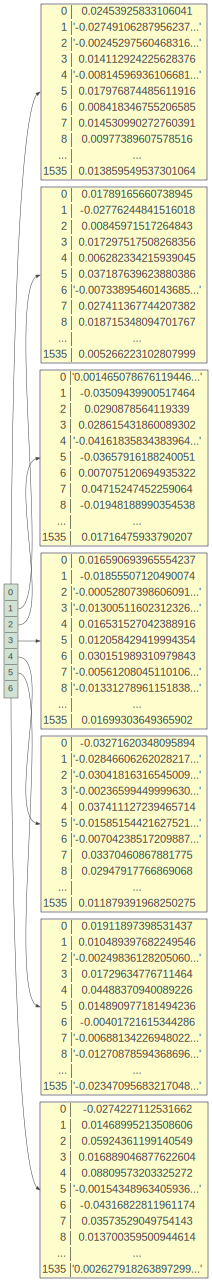

In [ ]:
# Note that there are 7 items in the list, each represents the embeddings (list of numerical values) for each of the inputs
# Each embedding vector contains 1,536 numerical values that represent the original text
# This cell uses the lolviz library to understand the response object, similar to the previous cells

import lolviz
lolviz.objviz(response)

<Axes: >

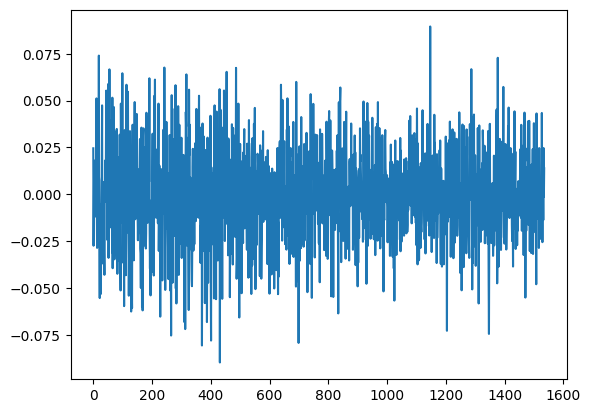

In [ ]:
# Due to the high dimensionality of the vectors, we can't easily visualize nor interpret them
import seaborn as sns
sns.lineplot(x=range(1536), y=response[0])

## Visualize Embedding

---

### Understanding UMAP for Data Analysts

- Uniform Manifold Approximation and Projection (UMAP) is a powerful dimensionality reduction technique that can be used to visualize high-dimensional data in a lower-dimensional space.
- Unlike other dimensionality reduction techniques, UMAP preserves both the local and global structure of the data, making it an excellent tool for exploratory data analysis.

### Using UMAP in Python

The UMAP algorithm is implemented in the `umap-learn` package in Python. Here's a simple example of how to use it:

---

```python
import umap
import numpy as np

# Assume embeddings is your high-dimensional data
embeddings = np.random.rand(100, 50)

reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embeddings)
```

---

In this example, `umap.UMAP()` creates a UMAP object, and `fit_transform()` fits the model to the data and then transforms the data to a lower-dimensional representation. The result, `umap_embeddings`, is a 2D array of the lower-dimensional embeddings of your data.


<br>

---

In this following example, we will use UMAP to visualize the 7 pieces of texts from the previous example

In [ ]:
import numpy as np
import pandas as pd
import umap # For compressing high-dimensional data (many columns) into lower-dimensional data (e.g. 2 columns)

import matplotlib.pyplot as plt
import seaborn as sns # For data visualization

In [ ]:
def get_projected_embeddings(embeddings, random_state=42):
    reducer = umap.UMAP(random_state=random_state).fit(embeddings)
    embeddings_2d_array = reducer.transform(embeddings)
    return pd.DataFrame(embeddings_2d_array, columns=['x', 'y'])

> 💡 Explanation for the cell above:
> - `def get_projected_embeddings(embeddings, random_state=0):` This line defines the function and its parameters. The function takes in two arguments: embeddings (your high-dimensional data) and random_state (a seed for the random number generator, which ensures that the results are reproducible).  
> - `reducer = umap.UMAP(random_state=random_state).fit(embeddings)` This line creates a UMAP object and fits it to your data. The fit method learns the structure of the data.  
> - `embeddings_2d_array = reducer.transform(embeddings)` This line transforms the high-dimensional data into a lower-dimensional space. The transformed data is stored in embeddings_2d_array.  
> - `return pd.DataFrame(embeddings_2d_array, columns=['x', 'y'])` This line converts the lower-dimensional data into a pandas DataFrame for easier manipulation and returns it. The DataFrame has two columns, 'x' and 'y', which represent the two dimensions of the reduced data.

In [ ]:
# Get the embeddings in a DataFrame object
projected_embeddings = get_projected_embeddings(response)

# Insert a new column to store the original texts
projected_embeddings['text'] = list_of_input_texts

projected_embeddings

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


,x,y,text
0,5.271393,5.707487,Flamingo spotted at the in the bird park
1,5.603629,6.498158,Sea otter seen playing at the marine park
2,6.066615,6.018225,Baby panda born at the city zoo
3,7.163785,4.859038,Python developers prefer snake_case for variab...
4,7.639285,6.099037,New JavaScript framework aims to simplify coding
5,7.064502,5.682024,C++ developers appreciate the power of OOP
6,7.880888,5.249054,Java is a popular choice for enterprise applic...


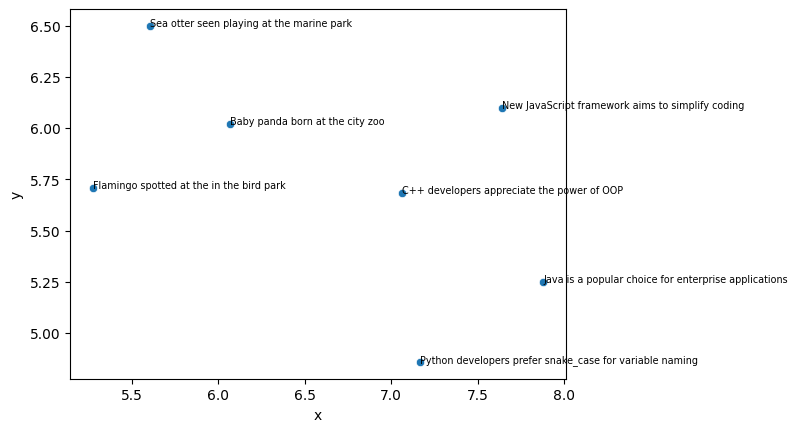

In [ ]:
# Create the Scatter plot that visualize the locations of the embeddings in the number space (commonly known as "vector space")
sns.scatterplot(x=projected_embeddings['x'], y=projected_embeddings['y'])

# Add labels to each point
for i in range(projected_embeddings.shape[0]):
    plt.text(x=projected_embeddings.loc[i, 'x'],
             y=projected_embeddings.loc[i, 'y'],
             s=projected_embeddings.loc[i, 'text'],
             fontsize='x-small')

- Observe the distances between the different texts
  - Although the text starts with *"Python developers prefer snake_case for variable naming"*, contains two animals, the embedding is further away from the three data points that truly focus about the "real" animals.
  - It is closer to the other data points that are focusing on programming/coding


---


### Understanding Cosine Similarity for LLM Embeddings

Cosine similarity is a metric used to measure how similar two vectors are, irrespective of their size. It's widely used in natural language processing to calculate the similarity between text documents represented as vector embeddings, such as those produced by Language Learning Models (LLMs).

The cosine similarity between two vectors is calculated as the cosine of the angle between them.
- If the vectors are identical, the angle is 0 and the cosine similarity is 1.
- If the vectors are orthogonal, the angle is 90 degrees and the cosine similarity is 0, indicating no similarity.

Cosine similarity is particularly useful for LLM embeddings because it effectively captures the semantic similarity between text documents. It's robust to the high dimensionality of LLM embeddings and is relatively efficient to compute, making it a popular choice for measuring the distance between LLM embeddings


---
---
<br>

# Setting up Credentials for langchain
---

We will be using `Langchain` for our Use Cases in the next section.
- The code cell below is to set up the credentials (i.e., the OPENAI API KEY) to allow `Langchain` to use OpenAI API Endpoints,
such as the `ChatCompletion` and `Embedding`.
- This also means that we will not directly use OpenAI's SDK in some of the use cases below.
- `Langchain`'s components like those `retriever` (that we discussed in the Knowledge Base) will handle the API calls to OpenAI's API endpoints automatically. All we need to do is to specify the `API_KEY` as required by Langchain, as indicated in the cell below.
- This way of providing credentials is called `environment variable assignment` or `setting environment variable`
- Specifically, it sets the value of the environment variable named `OPENAI_API_KEY` to the value stored in the Python variable `API_KEY` (we entered earlier in this notebook).
- Environment variables are used to configure and customize the behavior of software applications by allowing them to access external settings or secrets without hardcoding them directly into the code.
- We will learn more about setting the credentials  more efficiency and securly in later part of our training.


In [ ]:
import os

os.environ["OPENAI_API_KEY"] = API_KEY

---
---

<br>

# Use Cases of Embeddings
---

## Use Case #1: Semantic Search & Recommendation System

### Understanding Keyword Retrieval and Dense Retrieval

- Keyword retrieval and dense retrieval are two different methods used in information retrieval systems.

- **Keyword Retrieval**:
    - Keyword retrieval, also known as sparse retrieval, is a traditional method of information retrieval.
    - It involves matching the exact keywords in the query with the documents in the database.
    - This method is simple and explainable, but it has some limitations
    - It doesn’t fully capture the semantics of each term in the context of the whole text.
    - It may not perform well when the query words do not exactly match the words in the document.
- **Dense Retrieval (or Semantic Search)**:
    - Dense retrieval, on the other hand, uses dense vector representations (embeddings) of the text to capture the deep semantic relationship between queries and documents.
    - These vectors are usually generated by neural networks, particularly transformer-based models.
    - This method shows a huge improvement over keyword search as it captures the semantics of the text1. However, it’s more complex and computationally intensive than keyword retrieval.

<br>
    
- Here are the key differences between the two methods:
    - **Semantics**: Dense retrieval captures the semantics of the text, while keyword retrieval does not.
    - **Matching**: Keyword retrieval relies on exact keyword matching, while dense retrieval uses semantic matching.
    - **Performance**: Dense retrieval generally outperforms keyword retrieval, especially when the query words do not exactly match the words in the document.
    - **Complexity**: Dense retrieval is more complex and computationally intensive than keyword retrieval

[Reference for Products - https://www.developer.tech.gov.sg/products/all-products/](https://www.developer.tech.gov.sg/products/all-products/)

In [ ]:
# The variable `corpus`  contains a list of documents (text data).
# We are using the products & services from Reference https://www.developer.tech.gov.sg/products/all-products/
corpus = [
    'Cybersecurity. AI Document Parser (AISAY) – An AI-Powered Document Reader and Transcription API Service. AISAY is an AI-Powered Document Reader and Transcription API Service for public officers. Learn more here!',
    'Analytics. Analytics.gov – Enabling Data Exploitation for Whole-of-Government (WOG). Analytics.gov is a Whole-Of-Government (WOG) data exploitation platform to support the analysis of data by agencies.',
    'Productivity. Cloak – The Central Privacy Toolkit for Policy-Compliant Data Anonymisation. Cloak helps public officers to anonymise sensitive data based on public sector guidelines through a one-stop, self-service web application. Learn more here!',
    'DevOps. Container Stack (CStack) – Managed Platform for Apps using Kubernetes. Container Stack is a cloud-based container hosting platform and a Runtime component within Singapore Government Tech Stack.',
    'Data and APIs. Data.gov.sg — The One-Stop Open Data Portal for Publicly Available Singapore Government Datasets. Learn from Data.gov.sg, Singapore’s one-stop open data portal offering government datasets. Dive in now!',
    'Analytics. GovText – The Whole-of-Government Text Analytics Platform. Analyse your textual data efficiently with the GovText Natural Language Processing (NLP) platform for WOG. Discover more!',
    'Data and APIs. Monetary Authority of Singapore (MAS) APIs - Streamlining of Financial Applications through Data. The Monetary Authority of Singapore (MAS) provides APIs for developers, allowing MAS’ applications to be streamlined.',
    'Analytics. Whole-of-Government Application Analytics (WOGAA) - Improve Government Services with Data. WOGAA is an analytics & performance platform for public officers to monitor the health of their government websites and optimise the performance of their digital services with data.',
    'Data and APIs. Vault - A Central Data Discovery and Distribution Platform for WOG Vault is a platform where government data is consolidated, organised and made discoverable for public servants to explore, search and securely access.',
    'Productivity. Transcribe provides auto-transcription and localised Speech-to-Text services for Singapore government officers.',
    'Data and APIs. SingStat Table Builder. The SingStat Table Builder contains over 1,800 statistical data tables from 60 public sector agencies providing a comprehensive statistical view of Singapore’s economic and socio-demographic characteristics.',
    'Productivity. Postman — Deliver Messages to Citizens in Minutes. Postman is a multichannel cloud-based service for Singapore government agencies to send mass personalized messages in minutes.',
]

#### Keywords Retrieval

In [ ]:
# This library provides an implementation of the BM25 algorithm,
# which is commonly used for information retrieval and text search
from rank_bm25 import BM25Okapi

# Tokenizes each document in the corpus
# by splitting it into individual words based on spaces.
tokenized_corpus = [doc.split(" ") for doc in corpus]

# Initialize BM25
# The BM25Okapi model is now ready to compute relevance scores for queries against this corpus.
bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
# Now let's say we have the following query
query = "Data exploitation"

# The query is tokenized into individual words: tokenized_query = query.split(" ")
# The query must be tokenized in the same way as the corpus (list of input documents)
tokenized_query = query.split(" ")

# Computes BM25 scores for each document in the corpus based on the query.
doc_scores = bm25.get_scores(tokenized_query)

# Print the list of relevance scores corresponding to each document.
# It's  a position (index) based listing of the score,
# based on the original order of the text in our `corpus` variable
print(doc_scores)

[0.         2.17167558 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [ ]:
# Finding the Most Relevant Document:
import numpy as np
x = np.array(doc_scores)

# The argmax() function returns the index of the maximum value in the array.
# This line use "indexing" apprach to retrieve the most relevant document
# from the original corpus based on the highest BM25 scores.
corpus[x.argmax()]

'Analytics. Analytics.gov – Enabling Data Exploitation for Whole-of-Government (WOG). Analytics.gov is a Whole-Of-Government (WOG) data exploitation platform to support the analysis of data by agencies.'

> 💡 Experiemnt with different `query` to see how well the `Keyword-based Retriever` works and when does it hit its limitations

---

> ⚠️ The provided code demonstrates a basic implementation of the BM25 algorithm for keyword-based search.
> - However, it’s essential to recognize that real-world production-level keyword search systems are significantly more complex.
> - While this simplified BM25 example provides a foundational understanding, building robust search systems involves addressing these complexities.
> - Production-level search engines require a combination of information retrieval, machine learning, and engineering expertise to deliver accurate and efficient results.

---


<br>



#### Dense Retrieval

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [ ]:
query = "Data exploitation"

In [ ]:
# an embeddings model is initialized using the OpenAIEmbeddings class.
# The specified model is 'text-embedding-3-small'.
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [ ]:
# A vector store is created using the Chroma class.
# It stores embeddings for a given set of texts (documents).
# The embeddings_model is used to convert the texts into embeddings.
vectorstore = Chroma.from_texts(corpus, embeddings_model)

In [ ]:
# This line performs a similarity search within the vector store for the query
# The k=3 parameter specifies that we want to retrieve the top 3 most similar documents.
# The method returns both the similar documents and their associated relevance scores.
# These scores indicate how similar each retrieved document is to the query (higher value means highly similar).
vectorstore.similarity_search_with_relevance_scores(query, k=5)

[(Document(page_content='Analytics. Analytics.gov – Enabling Data Exploitation for Whole-of-Government (WOG). Analytics.gov is a Whole-Of-Government (WOG) data exploitation platform to support the analysis of data by agencies.'),
  0.20724719801034397),
 (Document(page_content='Analytics. GovText – The Whole-of-Government Text Analytics Platform. Analyse your textual data efficiently with the GovText Natural Language Processing (NLP) platform for WOG. Discover more!'),
  0.07087070152861263),
 (Document(page_content='Data and APIs. Data.gov.sg — The One-Stop Open Data Portal for Publicly Available Singapore Government Datasets. Learn from Data.gov.sg, Singapore’s one-stop open data portal offering government datasets. Dive in now!'),
  0.02929207682934243),
 (Document(page_content='Data and APIs. Vault - A Central Data Discovery and Distribution Platform for WOG Vault is a platform where government data is consolidated, organised and made discoverable for public servants to explore, se

> 💡 Experiemnt with different `query` to see how well the `Keyword-based Retriever` works on vague query and non-direct match
>
> - What is the drawbacks of this approach?
>
> - What if we change the parameter `k` to 6. Are all of those results make sense based on the query?
>
> - Any ideas / thoughts on how we can select those results that are more relevant to the query?
---

## Use Case #2: Building Predictive Models with Semantic Meanings of Text

---

We are preparing the data for our machine learning model later,
where we want to use the "description of the product" to derive at the classification of the products
e.g., is it `productivity`, `cybersecurity`, `analytics` or other categories

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("digital_products.csv")

# Display the first 10 rows of the dataframe
df[-10:]

,label,text
32,Productivity,Cloak – The Central Privacy Toolkit for Policy...
33,DevOps,Container Stack (CStack) – Managed Platform fo...
34,Data and APIs,Data.gov.sg — The One-Stop Open Data Portal fo...
35,Analytics,GovText – The Whole-of-Government Text Analyti...
36,Data and APIs,Monetary Authority of Singapore (MAS) APIs - S...
37,Analytics,Whole-of-Government Application Analytics (WOG...
38,Data and APIs,Vault - A Central Data Discovery and Distribut...
39,Productivity,Transcribe provides auto-transcription and loc...
40,Data and APIs,SingStat Table Builder. The SingStat Table Bui...
41,Productivity,Postman — Deliver Messages to Citizens in Minu...


In [ ]:
# Get the embeddings of the "description" (text column)
embeddings_vector_prods = get_embedding(df.text)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_vector_prods, df.label, test_size=0.3, random_state=42)

In [ ]:
# Choose a model
classifier = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=42)

In [ ]:
# Train the model
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [ ]:
# Evaluate the model
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[4 0 1 0 0]
 [0 1 1 0 0]
 [0 0 3 0 0]
 [0 0 1 0 0]
 [0 0 1 0 1]]


In [ ]:
# Print out the Accuracy of the Model in predicting the "cateogry of the products'
# Based on the limited training data, this is actual not a bad accuracy score
print(accuracy_score(y_test, y_pred))


0.6923076923076923


---
---

<br>

    

## Use Case #3: Retrieval-Augmented Generation

**\[ Why Context Augmentation? \]**

- LLMs offer a natural language interface between humans and data. Widely available models come pre-trained on huge amounts of publicly available data like Wikipedia, mailing lists, textbooks, source code and more.

- However, while LLMs are trained on a great deal of data, they are not trained on your data, which may be private or specific to the problem you’re trying to solve. It’s behind APIs, in SQL databases, or trapped in PDFs and slide decks.

- You may choose to fine-tune a LLM with your data, but:
    - Training a LLM is expensive.
    - Due to the cost to train, it’s hard to update a LLM with latest information.
    - Observability is lacking. When you ask a LLM a question, it’s not obvious how the LLM arrived at its answer.

- Instead of fine-tuning, one can use a context augmentation pattern called Retrieval-Augmented Generation (RAG) to obtain more accurate text generation relevant to your specific data. RAG involves the following high level steps:

    1. Retrieve information from your data sources first,
    2. Add it to your question as context, and
    3. Ask the LLM to answer based on the enriched prompt.

- In doing so, RAG overcomes all three weaknesses of the fine-tuning approach:
    - There’s no training involved, so it’s cheap.
    - Data is fetched only when you ask for them, so it’s always up to date.
    - LlamaIndex can show you the retrieved documents, so it’s more trustworthy.

---

**\[ Why LangChain for Context Augmentation? \]**

- Firstly, LangChain imposes no restriction on how you use LLMs. You can still use LLMs as auto-complete, chatbots, semi-autonomous agents, and more (see Use Cases on the left). It only makes LLMs more relevant to you.

- LangChain provides the following tools to help you quickly stand up production-ready RAG systems:

- Data connectors ingest your existing data from their native source and format. These could be APIs, PDFs, SQL, and (much) more.

- Data indexes structure your data in intermediate representations that are easy and performant for LLMs to consume.

- Engines provide natural language access to your data. For example:

- Query engines are powerful retrieval interfaces for knowledge-augmented output.

---

**\[ Overview of Steps in RAG \]**

- 1. **Document Loading**
	- In this initial step, relevant documents are ingested and prepared for further processing. This process typically occurs offline.
- 2. **Splitting & Chunking**
	- The text from the documents is split into smaller chunks or segments.
	- These chunks serve as the building blocks for subsequent stages.
- 3. **Storage**
	- The embeddings (vector representations) of these chunks are created and stored in a vector store.
	- These embeddings capture the semantic meaning of the text.
- 4. **Retrieval**
	- When an online query arrives, the system retrieves relevant chunks from the vector store based on the query.
	- This retrieval step ensures that the system identifies the most pertinent information.
- 5. **Output**
	- Finally, the retrieved chunks are used to generate a coherent response.
	- This output can be in the form of natural language text, summaries, or other relevant content.

![](https://abc-notes.data.tech.gov.sg/resources/img/topic-4-rag-overview.png)

In [ ]:
# Copied from above for ease-of-reference
import os

os.environ["OPENAI_API_KEY"] = API_KEY

### Document Loading

- Use document loaders to load data from a source as Document's.
  - A Document is a piece of text and associated metadata.
  - For example, there are document loaders for loading a simple .txt file, for loading the text contents of any web page, or even for loading a transcript of a YouTube video.

- See [official documentation on LangChain's Document Loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders) for different kinds of loaders for different sources.

In [ ]:
# In this example, we will load the Prompt Engineering Playbook

from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf")
pages = loader.load()

- Each page is a `Document` object.
- A `Document` contains text (`page_content`) and `metadata`.

In [ ]:
# Display the first page of the document
pages[0]

Document(metadata={'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf', 'page': 0}, page_content='  \n \n \nPROMPT ENGINEERING PLAYBOOK  \n(Beta  v3) \nLast updated 30 Aug 2023  \nProduced By GovTech Data Science & AI Division  \n \nThis version has been altered for public consumption. Public officers should check out LaunchPad \ndirectly to download the contextualised version of this Playbook for Public Service.  \n \n')

In [ ]:
# Display the metadata of the first page
pages[0].metadata

{'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf',
 'page': 0}

In [ ]:
# Display the content of the first page
pages[0].page_content

'  \n \n \nPROMPT ENGINEERING PLAYBOOK  \n(Beta  v3) \nLast updated 30 Aug 2023  \nProduced By GovTech Data Science & AI Division  \n \nThis version has been altered for public consumption. Public officers should check out LaunchPad \ndirectly to download the contextualised version of this Playbook for Public Service.  \n \n'

In [ ]:
# Let's count how many tokens are there
# by summing all the token counts from every page
import numpy as np

list_of_tokencounts = []
for page in pages:
    # Count the tokens in the content of each page
    # then append the count to the list
    list_of_tokencounts.append(count_tokens(page.page_content))

# Sum the token counts from all pages
print(f"There are total of {np.sum(list_of_tokencounts)} tokens")

There are total of 23623 tokens


In [ ]:
# On average, each page has the following number of tokens
# This information can be useful for us to decide on the spilting & chunking strategies
np.average(list_of_tokencounts)

176.2910447761194

### Splitting & Chunking

![](https://abc-notes.data.tech.gov.sg/resources/img/topic-4-rag-spliting.png)



**[ Different Types of Spliters ]**

When working with large chunks of text, breaking them down into smaller, more manageable units is crucial for effective analysis and processing. This is where text splitters come in.
Text splitters are algorithms designed to segment text based on specific criteria, ensuring that the resulting chunks are coherent and meaningful. However, with a variety of splitters available, selecting the right one for your needs can be daunting.


**Factors to Consider**:
- **Text Structure**: Is your text unstructured, or does it follow a specific format like Markdown or HTML?
- **Desired Chunk Size**: Are you looking for sentence-level splits, paragraph-level splits, or something else entirely?
- **Language Specifics**: Does your text contain code snippets or elements specific to a programming language?
- **Metadata Requirements**: Do you need the splitter to preserve information about the text's original structure?


Let's delve into the different types of splitters and their strengths:
- `CharacterTextSplitter()` ->Implementation Of splitting text that looks at characters.

- `MarkdownHeaderTextSplitter()` -> lmplementation Of splitting markdown files based on specified headers.

- `TokenTextSplitter()` -> lmplementation Of splitting text that looks at tokens.

- `SentenceTransformersTokenTextSpIitter()`  -> lmplementation Ofsplitting text that IOOks at tO kens.

- `RecursiveCharacterTextSplitted()`  -> lmplementation Of splitting textthat looks at characters. Recursively tries tO split by differentcha racters to find one that works.

- `Language()` -> for CPP，Python， Ruby，Markdown, etc

- `NLTKTextSpIitter()` -> lmplementation Of splitting text that | 00 ks atsentences using NLTK (Natural l-anguage TOOI Kit)

- `SpacyTextSplitter()` -> lmplementation Of splitting text that IOOks atsentences using Spacy

|    Name   |               Splits On               | Adds Metadata |                                                                                        Description                                                                                       |
|:---------:|:-------------------------------------:|:-------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Recursive | A list of user defined characters     |               | Recursively splits text. Splitting text recursively serves the purpose of trying to keep related pieces of text next to each other. This is the recommended way to start splitting text. |
| HTML      | HTML specific characters              | ✅             | Splits text based on HTML-specific characters. Notably, this adds in relevant information about where that chunk came from (based on the HTML)                                           |
| Markdown  | Markdown specific characters          | ✅             | Splits text based on Markdown-specific characters. Notably, this adds in relevant information about where that chunk came from (based on the Markdown)                                   |
| Code      | Code (Python, JS) specific characters |               | Splits text based on characters specific to coding languages. 15 different languages are available to choose from.                                                                       |
| Token     | Tokens                                |               | Splits text on tokens. There exist a few different ways to measure tokens.                                                                                                               |
| Character | A user defined character              |               | Splits text based on a user defined character. One of the simpler methods.                                                                                                               |

---
- Instead of using the PDF, let's start with a simple text so we better understand how the splitters work.

In [ ]:
# Basic Document Splitting

from langchain.text_splitter import CharacterTextSplitter

# \n is a newline character
# "\" at the end of the line is used to make sure the text continue on the next line
# It allows long statements to be split across multiple lines for improved readability,
# preventing the need for horizontal scrolling in code editors.

some_text = """When writing documents, writers will use document structure to group content. \n\n
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n
Paragraphs are often delimited with a carriage return or two carriage returns. \
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space. \
and words are separated by space."""

# \n\n is often used to separate paragraphs
print(some_text)

When writing documents, writers will use document structure to group content. 


This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. 


Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space. and words are separated by space.


> 💡 How `CharacterTextSpliiter` works
> - The CharacterTextSplitter splits text only at designated separators, which are double newline characters (\n\n) by default.
> - The chunk_size parameter sets the maximum size of each split chunk.
> - If a text segment begins with **N** characters, contains a separator, and has **M** more characters before the next separator, the first chunk will be **N** characters long if chunk_size is smaller than the total length of that segment (**N** + **M** + len(separator)).
> - If you're interested, you can dive into the workings of the this Class [here](https://github.com/langchain-ai/langchain/blob/253ceca76a027a9c70b51f3ccf5ad5bfad4cf672/libs/text-splitters/langchain_text_splitters/character.py#L9)

In [ ]:
# Splitting the text: The split_text method of the r_splitter object is called with some_text as the argument.
# This method splits the input text into chunks according to the chunk_size and chunk_overlap parameters specified when the r_splitter object was created.
# `CharacterTextSplitter` splits the text into chunks based on "\n\n"
r_splitter = CharacterTextSplitter(
    chunk_size=50,
    chunk_overlap=5
)

r_splitter.split_text(some_text)

['When writing documents, writers will use document structure to group content.',
 "This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document.",
 'Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space. and words are separated by space.']

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter_ = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=50,
    chunk_overlap=10,

    # length_function=count_tokens
)

text_splitter_.split_text(some_text)


['When writing documents, writers will use document',
 'document structure to group content.',
 "This can convey to the reader, which idea's are",
 'are related. For example, closely related ideas',
 'ideas are in sentances. Similar ideas are in',
 'are in paragraphs. Paragraphs form a document.',
 'Paragraphs are often delimited with a carriage',
 'carriage return or two carriage returns. Carriage',
 'Carriage returns are the "backslash n" you see',
 'you see embedded in this string. Sentences have a',
 'have a period at the end, but also, have a space.',
 'a space. and words are separated by space.']

---

Now let's go back to our PDF example and apply the `RecursiveCharacterTextSplitter` on the PDF file.

In [ ]:
# Testing on PDF

from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf")
pages = loader.load()


from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=500,
    chunk_overlap=50,
    length_function=count_tokens
)
# Note that in this example, we pass the `count_tokens` function as the `length_function` parameter
# By doing this, the text_splitter will use the `count_tokens` function to calculate the length of the text (in tokens)
# instead of the number of characters (default behavior).


splitted_documents = text_splitter.split_documents(pages)

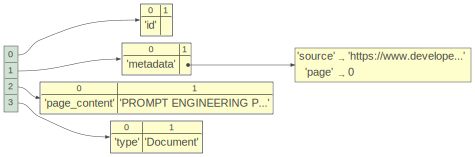

In [ ]:
# Display the first splitted document
lolviz.objviz(splitted_documents[0])

> 💡 Explanation

- **Separators**:
    - The separators parameter is a list of strings that the algorithm will use to split the text.
    - The algorithm will try to split the text using the first separator in the list.
    - If the resulting chunks are still larger than the chunk_size, it will try to split them further using the next separator in the list, and so on.
    - This process continues until all chunks are smaller than the chunk_size or until all separators have been used.
- **Chunk Size**:
    - The chunk_size parameter is the maximum size for each chunk of text.
    - If after using all separators, there are still chunks that are larger than the chunk_size, the algorithm will split these chunks at the chunk_size character, regardless of where this falls in the text.
- **Chunk Overlap**:
    - The chunk_overlap parameter determines how many characters from the end of one chunk should be repeated at the start of the next chunk.
    - This can be useful to provide context when processing each chunk independently.
- **Length Function**:
    - The length_function parameter is a function that calculates the ‘length’ of a chunk.
    - This could be a simple function like len (which counts characters), or a more complex function like count_tokens (which counts words or tokens).

`RecursiveCharacterTextSplitter` will first try to split by the separators. If the resulting chunks are still too large, it will then split them further until they are smaller than the chunk_size. The chunk_overlap is applied after all splitting is done. The length_function is used throughout this process to measure the size of the chunks. It’s important to note that the separators are tried in the order they are given in the list, and the algorithm will always try to split by separators before resorting to splitting by chunk_size

In [ ]:
# Show the number of tokens in each of the splitted documents
for doc in splitted_documents:
    print(count_tokens(doc.page_content))

67
456
45
37
454
150
463
188
299
222
143
35
256
231
305
118
321
119
138
104
372
304
285
133
115
71
75
54
362
51
29
150
209
254
128
142
128
158
89
103
68
9
104
196
43
9
56
282
125
56
67
105
9
111
117
9
177
84
78
27
31
29
57
68
118
89
109
9
134
131
49
29
83
256
100
9
150
31
80
9
129
99
177
9
363
343
97
408
107
80
52
31
159
128
52
9
77
116
130
363
176
439
258
132
126
324
155
367
204
286
232
96
318
369
302
51
202
435
317
313
137
174
326
375
235
317
374
305
193
193
261
278
32
442
114
438
252
317
87
52


In [ ]:
splitted_documents[15]

Document(metadata={'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf', 'page': 12}, page_content='Prompt Engineering Playbook  \nPage  13 give you the same result (even if it may be different from what you see here). You can see that the \nresult is usually more “conservative”.  \n \nHowever, with a creativity setting of High, you can run it a few times to see the different \nresults . The first try yielded this. The AI seems to “think out of the box” now.  \n \nA second try yielded this instead.  \n \nExplore with the different Creativity settings especially if you feel that your prompts are not getting \nthe responses you need.')

In [ ]:
splitted_documents[16]

Document(metadata={'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf', 'page': 13}, page_content='Prompt Engineering Playbook  \nPage  14 Zero Shot, One Shot, Few Shots  \nYou may have heard someone praise ChatGPT before with something like this “Wow, it \nperforms very well even with zero shot learning”.  \nIn this context  of using such LLM -powered chat , one shot , few shots , and zero shots  refer \nto how much data you are exposing to the pre -trained model (e.g.  OpenAI’s ChatGPT 3.5 Turbo) \nto help it with formulating its respon se. More specifically,  \n• Few-shot learning  is where you provide multiple examples to the AI model, and it is able \nto generalize to new examples of what you need . \n• One shot learning  is similar,  but instead of multiple examples, you only pass in one.  \n• Zero -shot learning  is where you directly pose a question type of machine learning

In [ ]:
splitted_documents[17]

Document(metadata={'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf', 'page': 14}, page_content='Prompt Engineering Playbook  \nPage  15 With few-shots  learning, you will type in a prompt like this.  \n \nYou can see that once you’ve shown the AI how you want the response to be like, and how \nit should look like, the AI is able to emulate it pretty well. Since the samples given to the AI ar e a \nsingle word of positive, negative or neutral, the AI learns that you would like the response to be \njust a single word, which is “positive” , and dutifully complies.  Here’s another example.')

⚠️ This code example primarily is for us to demo the capabilities of `RecursiveCharacterTextSplitter` for breaking down a PDF document into smaller chunks. It highlights how you can customize the splitting process using different separators and control chunk size and overlap.

**However, it's crucial to understand that optimal splitting and chunking strategies are highly dependent on the document's content and structure.** While this example demonstrates a character-based approach, more advanced techniques often prove more effective (we will cover a some of the advanced techniques in the next topic).

---

Splitting by page can be problematic, particularly in some cases, because:

* **Pages often contain disparate information:** A single page might house headings, paragraphs, tables, and figures, making it a poor unit for preserving semantic coherence.
* **Important context can be lost:** Splitting mid-sentence or mid-paragraph across pages can sever crucial contextual information, hindering comprehension.

While this example provides a foundational understanding of text splitting, exploring alternative methods like semantic chunking is highly recommended for real-world applications.


<br>

---

### Embedding & Vectorstores

One of the most common ways to store and search over unstructured data is to embed it and store the resulting embedding vectors, and then at query time to embed the unstructured query and retrieve the embedding vectors that are 'most similar' to the embedded query. A vector store takes care of storing embedded data and performing vector search for you.

Most vector stores can also store metadata about embedded vectors and support filtering on that metadata before similarity search, allowing you more control over returned documents.

![](https://abc-notes.data.tech.gov.sg/resources/img/topic-4-rag-storage.png)

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

In [ ]:
# An embeddings model is initialized using the OpenAIEmbeddings class.
# The specified model is 'text-embedding-3-small'.
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')


# For more info on using the Chroma class, refer to the documentation https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/
vector_store = Chroma.from_documents(
    collection_name="prompt_engineering_playbook",
    documents=splitted_documents,
    embedding=embeddings_model,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not neccesary
)

In [ ]:
# Show the number of documents in the vector store
vector_store._collection.count()

140

In [ ]:
# Peek at one of the documents in the vector store
vector_store._collection.peek(limit=1)

{'ids': ['00a3e28f-07db-482d-aea8-d3f1f4b9f69d'],
 'embeddings': [[-0.020841309800744057,
   0.01575116626918316,
   0.00071138289058581,
   0.00028786706388927996,
   -0.01503006275743246,
   -0.021703805774450302,
   0.005927896127104759,
   0.0017682946054264903,
   -0.0011399800423532724,
   0.03396257013082504,
   0.0560198575258255,
   -0.06973496824502945,
   0.013877710327506065,
   -0.041060492396354675,
   0.0410887710750103,
   -0.014549327082931995,
   0.017575133591890335,
   0.008130090311169624,
   0.01273242849856615,
   -0.021081676706671715,
   0.029805617406964302,
   0.025351742282509804,
   -0.03362322598695755,
   0.04753628373146057,
   -0.004775544162839651,
   0.0078119561076164246,
   0.04301171377301216,
   0.07035709172487259,
   -0.005729946307837963,
   -0.002189822029322386,
   0.009515740908682346,
   -0.03489576280117035,
   -0.027218127623200417,
   -0.06012025102972984,
   0.0001578518858877942,
   -0.012096160091459751,
   0.049657177180051804,
   0.

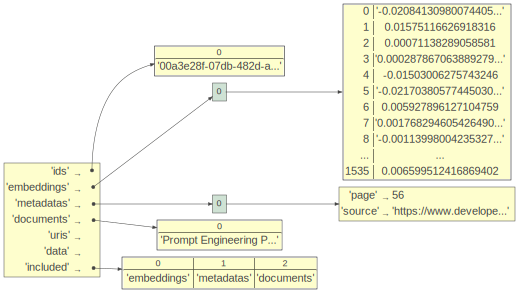

In [ ]:
lolviz.objviz(vector_store._collection.peek(limit=1))

In [ ]:
# How to load the vector store from the disk
vector_store = Chroma("prompt_engineering_playbook",
                      embedding_function=embeddings_model,
                      persist_directory= "./chroma_langchain_db")

<br>

---

### Retrieval

![](https://abc-notes.data.tech.gov.sg/resources/img/topic-4-rag-retrieval.png)

 ### Basic Retrieval

In [ ]:
vector_store.similarity_search('Zero Shot', k=3)

[Document(metadata={'page': 52, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  53'),
 Document(metadata={'page': 87, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  88  \n \n \n \n \n \n \n \nAdvanced Pro Tips & Tricks  \n"The more that you read, the more things you will know. The more that you learn, \nthe more places you\'ll go."  \n- Dr. Seuss'),
 Document(metadata={'page': 49, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  50')]

In [ ]:
vector_store.similarity_search_with_relevance_scores('Zero Shot', k=3)

[(Document(metadata={'page': 52, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  53'),
  0.006146207738917719),
 (Document(metadata={'page': 87, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  88  \n \n \n \n \n \n \n \nAdvanced Pro Tips & Tricks  \n"The more that you read, the more things you will know. The more that you learn, \nthe more places you\'ll go."  \n- Dr. Seuss'),
  0.004277585063338751),
 (Document(metadata={'page': 49, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  50'),
  0.003938977282402

### Question & Answer

![](https://d27l3jncscxhbx.cloudfront.net/lib/media/img-20240421150029496.png)

- Multiple relevant documents have been retrieved from the vector store
- Potentially compress the relevant splits to fit into the LLM context
- Send the information along with our question to an LLM to select and format an answer

#### RetrievalQA Chain

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
from langchain_openai import ChatOpenAI

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    ChatOpenAI(model='gpt-4o-mini'),
    retriever=vector_store.as_retriever(k=20)
)

qa_chain.invoke("Why LLM hallucinate?")

{'query': 'Why LLM hallucinate?',
 'result': 'LLMs hallucinate because they generate text that appears coherent and contextually relevant but can be factually incorrect or misleading. This issue arises from the inherent nature of how LLMs are trained on massive datasets, which do not include a built-in fact-checking mechanism. The models rely on patterns and probabilities to construct responses, which can sometimes lead to the generation of plausible but entirely fabricated information. Additionally, the responses can seem surprisingly real, making it difficult to spot inaccuracies without careful verification.'}

---

The k value in the retriever=vector_store.as_retriever(k=20) line determines the number of documents retrieved from the database to be used as context for the question-answering process. Here are the implications of using a smaller or bigger k value:

- Smaller k value (e.g., k=5):
    - Pros:
        - Faster retrieval and processing time since fewer documents are being fetched and analyzed.
        - Less tokens usage.
    - Cons:
        - May miss relevant documents, leading to less accurate or incomplete answers.
        - Higher risk of hallucination if the retrieved documents do not provide sufficient context.


- Bigger k value (e.g., k=50):
    - Pros:
        - Higher chance of retrieving all relevant documents, potentially leading to more accurate and comprehensive answers.
        - Better context for the model, reducing the risk of hallucination.
    - Cons:
        - Slower retrieval and processing time due to the larger number of documents.
        - Increased tokens usage.
        - Potential for information overload, where too much context might confuse the model.
---

#### With Custom Q&A Prompt

In [ ]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# Run chain
qa_chain = RetrievalQA.from_chain_type(
    ChatOpenAI(model='gpt-4o-mini'),
    retriever=vector_store.as_retriever(),
    return_source_documents=True, # Make inspection of document possible
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [ ]:
qa_chain.invoke("Why LLM hallucinate?")

{'query': 'Why LLM hallucinate?',
 'result': 'LLMs hallucinate because they generate text based on patterns learned from massive datasets without a built-in fact-checking mechanism. They often produce coherent responses that may appear accurate but can be factually incorrect or misleading. This issue arises from their reliance on inference rather than actual data verification. Thanks for asking!',
 'source_documents': [Document(metadata={'page': 18, 'source': 'https://www.developer.tech.gov.sg/products/collections/data-science-and-artificial-intelligence/playbooks/prompt-engineering-playbook-beta-v3.pdf'}, page_content='Prompt Engineering Playbook  \nPage  19 Hallucination Problems  \nOne important thing to take note of when using such AI powered by Large Language \nModels (LLMs) is that they often generate text that appears coherent and contextually relevant \nbut is factually incorrect or misleading . We call these hallucination problems . This issue arises \ndue to the inherent natu

This code sets up a prompt template for a question-answering chain using a language processing model and a retriever object. It allows for the generation of answers based on provided context and a given question. Let's break it down step by step:


- `A multi-line string` is defined and assigned to the variable template. This string serves as a template for constructing prompts. It includes placeholders like `{context}`, `{question}`, and `{answer}` that will be filled in with actual values later.

- The code defines a variable `QA_CHAIN_PROMPT` and assigns it the value of `PromptTemplate`.from_template(template). This line creates an instance of the `PromptTemplate` class using the from_template method, passing in the template string as an argument. This instance will be used as a prompt template for the question-answering chain.

- The code then initializes a qa_chain variable by calling the `RetrievalQA.from_chain_type()` method. It takes several arguments:
    - `ChatOpenAI(model='gpt-4o-mini')`: This argument specifies the model to be used for the chat-based language processing. I

    - `retriever=vector_store.as_retriever()`: This argument specifies a retriever object, likely responsible for retrieving relevant documents or information for the question-answering process. The `vector_store.as_retriever()` method is called to create this retriever object.

    - `return_source_documents=True`: This argument indicates that the source documents should be returned along with the answers. It allows for inspection of the documents used in the retrieval process.
    
    - `chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}`: This argument provides additional keyword arguments to the from_chain_type() method. It includes a dictionary with a key "prompt" and the value of the QA_CHAIN_PROMPT variable, which is the prompt template created earlier.
